# Multiple Instance Learning with Graph Neural Networks


## Proposed Method Description

In this notebook, we explore **Multiple Instance Learning (MIL)** by leveraging **Graph Neural Networks (GNNs)** to learn bag-level representations. We will treat each bag of instances as a graph, where the individual instances are treated as nodes, and the edges between them capture their relationships. The goal is to explore the structural information within the bags and use GNNs to learn meaningful embeddings that can be used for **bag-level classification**.

We will use the MNIST Bags dataset, where each bag consists of multiple images (instances) of digits, and the bag-level label corresponds to whether the bag consists of 9 or not.

### Imports

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.1 MB/s eta 0:00:00


In [2]:
!pip install chamferdist

  Preparing metadata (setup.py) ... done
  Created wheel for chamferdist: filename=chamferdist-1.0.3-cp310-cp310-linux_x86_64.whl size=6458934 sha256=54668a8dd2ac7e21a26ca24a35e2c3ab01e46ba0cfaf5a2a0562b0c4cb9d28eb
  Stored in directory: /root/.cache/pip/wheels/e4/18/72/8195757e9529dc3e3d0b63c729c3fa5b6b753f47106e675741
Successfully built chamferdist


In [3]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, ClusterGCNConv, global_max_pool, max_pool, dense_diff_pool, DenseSAGEConv
from torch_geometric.data import NeighborSampler, Data
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_ut
from chamferdist import ChamferDistance
import numpy as np
from torchvision import datasets, transforms

### Dataset
Creating a dataset object that contains bags and their labels.

In [4]:
class MNIST_Bags(data_utils.Dataset):
    def __init__(self, target_number=9, mean_bag_length=10, var_bag_length=2, num_bag=250, seed=1, train=True):
        self.target_number = target_number
        self.mean_bag_length = mean_bag_length
        self.var_bag_length = var_bag_length
        self.num_bag = num_bag
        self.train = train

        self.r = np.random.RandomState(seed)

        self.num_in_train = 60000
        self.num_in_test = 10000

        if self.train:
            self.train_bags_list, self.train_labels_list = self._create_bags()
        else:
            self.test_bags_list, self.test_labels_list = self._create_bags()

    def _create_bags(self):
        if self.train:
            loader = data_utils.DataLoader(datasets.MNIST('../datasets',
                                                          train=True,
                                                          download=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))])),
                                           batch_size=self.num_in_train,
                                           shuffle=False)
        else:
            loader = data_utils.DataLoader(datasets.MNIST('../datasets',
                                                          train=False,
                                                          download=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((0.1307,), (0.3081,))])),
                                           batch_size=self.num_in_test,
                                           shuffle=False)

        for (batch_data, batch_labels) in loader:
            all_imgs = batch_data
            all_labels = batch_labels

        bags_list = []
        labels_list = []

        for i in range(self.num_bag):
            bag_length = int(self.r.normal(self.mean_bag_length, self.var_bag_length, 1))
            if bag_length < 1:
                bag_length = 1

            if self.train:
                indices = torch.LongTensor(self.r.randint(0, self.num_in_train, bag_length))
            else:
                indices = torch.LongTensor(self.r.randint(0, self.num_in_test, bag_length))

            labels_in_bag = all_labels[indices]
            labels_in_bag = labels_in_bag == self.target_number

            bags_list.append(all_imgs[indices])
            labels_list.append(labels_in_bag)

        return bags_list, labels_list

    def __len__(self):
        if self.train:
            return len(self.train_labels_list)
        else:
            return len(self.test_labels_list)

    def __getitem__(self, index):
        if self.train:
            bag = self.train_bags_list[index]
            label = [max(self.train_labels_list[index]), self.train_labels_list[index]]
        else:
            bag = self.test_bags_list[index]
            label = [max(self.test_labels_list[index]), self.test_labels_list[index]]

        return bag, label


#### Visualize the data

Visulaizing two bags of our dataset .

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.15MB/s]


Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



<ipython-input-4-191b28251b42>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bag_length = int(self.r.normal(self.mean_bag_length, self.var_bag_length, 1))


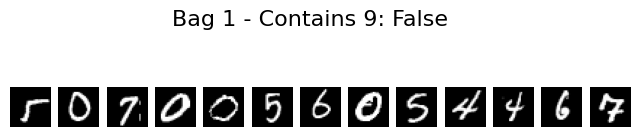

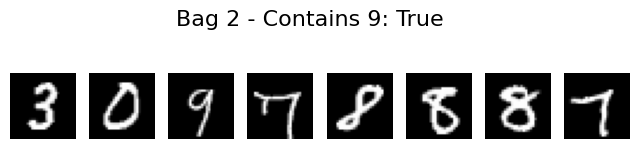

In [5]:
# Create the dataset
dataset = MNIST_Bags(train=True, num_bag=2)

# Extract two bags and their labels
bag1, label1 = dataset[0]
bag2, label2 = dataset[1]

# Convert tensors to numpy arrays for visualization
bag1_images = bag1.numpy()
bag2_images = bag2.numpy()

# Labels (max label and all labels)
max_label1, all_labels1 = label1
max_label2, all_labels2 = label2

plt.figure(figsize=(8, 2))
for i, image in enumerate(bag1_images):
    plt.subplot(1, len(bag1_images), i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Bag 1 - Contains 9: {max_label1}", fontsize=16)
plt.show()

plt.figure(figsize=(8, 2))
for i, image in enumerate(bag2_images):
    plt.subplot(1, len(bag2_images), i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Bag 2 - Contains 9: {max_label2}", fontsize=16)
plt.show()

#### Data Loaders
Useing DataLoader to get the train and test loaders.

In [6]:
import torch
from torch.utils.data import DataLoader

train_dataset = MNIST_Bags(target_number=9, mean_bag_length=10, var_bag_length=2, num_bag=300, seed=1, train=True)
test_dataset = MNIST_Bags(target_number=9, mean_bag_length=10, var_bag_length=2, num_bag=100, seed=1, train=False)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

<ipython-input-4-191b28251b42>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bag_length = int(self.r.normal(self.mean_bag_length, self.var_bag_length, 1))


### Model

Here we will define our GraphBasedMIL model, complete each funcion based on the comments.



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GraphBasedMIL(nn.Module):
    """
    A neural network class for graph-based Multiple Instance Learning (MIL).
    This model learns to process a bag of instances and predict the class label for the bag.
    """

    def __init__(self):
        """
        Initialize the GraphBasedMIL model with various layers and parameters.

        Outputs:
        - A Graph-based MIL model instance with layers for feature extraction, GNN embedding,
          clustering, and MLP for final classification.
        """
        super(GraphBasedMIL, self).__init__()
        self.L = 50
        self.C = 1
        self.classes = 2

        self.n = 50
        self.n_step = 0.5
        self.num_adj_parm = 0.1

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(50 * 4 * 4, self.L),
            nn.ReLU(),
        )

        self.gnn_embd = DenseSAGEConv(self.L, self.L)
        self.bn1 = nn.BatchNorm1d(self.L)

        self.gnn_pool = DenseSAGEConv(self.L, self.C)
        self.bn2 = torch.nn.BatchNorm1d(self.C)
        self.mlp = nn.Linear(self.C, self.C, bias=True)

        self.gnn_embd2 = DenseSAGEConv(self.L, self.L)
        self.bn3 = nn.BatchNorm1d(self.L)

        input_layers = int(self.L * self.C)
        hidden_layers = int(self.L * self.C / 2)
        output_layer = self.classes
        self.lin1 = nn.Linear(input_layers, hidden_layers, bias=True)
        self.lin2 = nn.Linear(hidden_layers, output_layer, bias=True)


    def forward(self, x):
        """
        Forward pass of the GraphBasedMIL model.

        Inputs:
        - x (torch.Tensor): Input tensor of shape [batch_size, channels, height, width].

        Outputs:
        - Y_prob (torch.Tensor): Predicted class probabilities.
        - loss (torch.Tensor): Total loss value including auxiliary and main losses.
        """
        x = x.squeeze(0)
        H = self.feature_extractor_part1(x)
        H = H.view(-1, 50 * 4 * 4)
        H = self.feature_extractor_part2(H)

        X = H
        A = torch.ones((len(X), len(X)), device=device)

        Z = F.leaky_relu(self.gnn_embd(X, A), negative_slope=0.01)
        loss_emb_1 = self.auxiliary_loss(A, Z)

        S = F.leaky_relu(self.gnn_pool(X, A), negative_slope=0.01)
        S = F.leaky_relu(self.mlp(S), negative_slope=0.01)

        X, A, l1, e1 = dense_diff_pool(Z, A, S)

        X = F.leaky_relu(self.gnn_embd(X, A), negative_slope=0.01)
        loss_emb_2 = self.auxiliary_loss(A, X)

        X = X.view(1, -1)

        X = F.leaky_relu(self.lin1(X), 0.01)
        X = F.leaky_relu(self.lin2(X), 0.01)

        Y_prob = F.softmax(X.squeeze(), dim=0)

        return Y_prob, (l1 + loss_emb_1 + loss_emb_2)

    def convert_bag_to_graph_(self, bag, N):
        """
        Converts a bag of instances to a graph, where each instance is a node.

        Inputs:
        - bag (torch.Tensor): Bag of instance features.
        - N (float): Threshold distance for edge creation.

        Outputs:
        - bag (torch.Tensor): Node features for the graph.
        - edge_index (torch.Tensor): Indices of edges between nodes.
        """
        edge_index = []
        chamferDist = ChamferDistance()
        for cur_i, cur_node in enumerate(bag):
            for alt_i, alt_node in enumerate(bag):
                if cur_i != alt_i and self.euclidean_distance_(cur_node, alt_node) < N:
                    edge_index.append(torch.tensor([cur_i, alt_i]).cuda())

        if len(edge_index) < self.num_adj_parm * bag.shape[0]:
            print(f"INFO: get number of adjecment {len(edge_index)}, min len is {self.num_adj_parm * bag.shape[0]}")
            return self.convert_bag_to_graph_(bag, N = (N + self.n_step))

        return bag, torch.stack(edge_index).transpose(1, 0)


    def euclidean_distance_(self, X, Y):
        """
        Compute the Euclidean distance between two vectors.

        Inputs:
        - X (torch.Tensor): First vector.
        - Y (torch.Tensor): Second vector.

        Outputs:
        - dist (torch.Tensor): Euclidean distance between X and Y.
        """
        return torch.sqrt(torch.dot(X, X) - 2 * torch.dot(X, Y) + torch.dot(Y, Y))

    def auxiliary_loss(self, A, S):
        """
        Computes the auxiliary loss for graph structure regularization.

        Inputs:
        - A (torch.Tensor): Adjacency matrix of the graph.
        - S (torch.Tensor): Node features (softmax probabilities).

        Outputs:
        - link_loss (torch.Tensor): Computed loss based on adjacency and node features.
        """
        A = A.unsqueeze(0) if A.dim() == 2 else A
        S = S.unsqueeze(0) if S.dim() == 2 else S

        S = torch.softmax(S, dim=-1)

        link_loss = A - torch.matmul(S, S.transpose(1, 2))
        link_loss = torch.norm(link_loss, p=2)
        link_loss = link_loss / A.numel()

        return link_loss

    def calculate_classification_error(self, output, target, TP, TN, FP, FN):
        """
        Calculate the classification error metrics (True Positive, True Negative, False Positive, False Negative).

        Inputs:
        - output (torch.Tensor): The predicted class probabilities (e.g., from softmax).
        - target (torch.Tensor): The ground truth labels.
        - TP (list): True Positives count (mutable).
        - TN (list): True Negatives count (mutable).
        - FP (list): False Positives count (mutable).
        - FN (list): False Negatives count (mutable).

        Outputs:
        - Updates TP, TN, FP, FN based on the predicted and target labels.

        Instructions:
        - Implement the logic to find the predicted class using `torch.argmax(output)` (for binary classification).
        - Compare the prediction with the target:
            - If the prediction and target both equal 1, increment TP.
            - If the prediction is 1 and the target is 0, increment FP.
            - If the prediction is 0 and the target is 1, increment FN.
            - If both prediction and target are 0, increment TN.
        """
        pred = torch.argmax(output)

        if pred.eq(1) and target.eq(1):
            TP[0] += 1

        elif pred.eq(1) and target.eq(0):
            FP[0] += 1

        elif pred.eq(0) and target.eq(1):
            FN[0] += 1

        elif pred.eq(0) and target.eq(0):
            TN[0] += 1

    def cross_entropy_loss(self, output, target):
        """
        Calculate the cross-entropy loss for the classification task.

        Inputs:
        - output (torch.Tensor): Model output (raw logits or probabilities).
        - target (torch.Tensor or list): Ground truth labels (should be in long type for classification).

        Outputs:
        - l1 (torch.Tensor): Cross-entropy loss.

        Instructions:
        - If `output` has only one dimension, add an extra dimension to match the expected input format.
        - Convert `target` to a tensor of type `long` and move to the GPU if necessary.
        - Use the built-in `CrossEntropyLoss` from PyTorch to compute the loss.
        - Return the computed cross-entropy loss.
        """
        output = output.unsqueeze(0) if output.dim() == 1 else output
        target = torch.tensor(target, dtype=torch.long).cuda()
        loss = nn.CrossEntropyLoss()
        l1 = loss(output, target)

        return l1

    def calculate_objective(self, X, target):
        """
        Calculate the objective function that combines the likelihood loss and any regularization terms.

        Inputs:
        - X (torch.Tensor): Input features or data used for forward pass.
        - target (torch.Tensor or list): Ground truth labels.

        Outputs:
        - neg_log_likelihood (float): The negative log-likelihood (log loss).

        Instructions:
        - Convert the `target` to float type for compatibility with the computation.
        - Pass the input `X` through the forward pass to get predicted probabilities (`Y_prob`) and auxiliary loss (`l1`).
        - Clamp the predicted probabilities (`Y_prob`) to prevent log(0) errors.
        - Compute the negative log-likelihood using the target labels and predicted probabilities.
        - Return the computed negative log-likelihood.
        """
        target = target.float()
        Y_prob, l1 = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (target * torch.log(Y_prob) + (1. - target) * torch.log(1. - Y_prob))  # negative log bernoulli

        return neg_log_likelihood.data[0]



### Training

In [9]:
def train(model, optimizer, train_loader):
    """
    Train the model for one epoch.

    Inputs:
    - model: The model to train.
    - optimizer: The optimizer to use for gradient descent.
    - train_loader: DataLoader object that provides batches of training data.

    Outputs:
    - train_loss (float): Average training loss for the epoch.
    - Accuracy (float): Accuracy of the model on the training set.
    - Precision (float): Precision of the model on the training set.
    - Recall (float): Recall of the model on the training set.
    - F1 (float): F1 score of the model on the training set.

    Instructions:
    - Set the model to training mode using `model.train()`.
    - Initialize variables to track loss and metrics: `train_loss`, `TP`, `TN`, `FP`, `FN`, and `ALL`.
    - Loop over batches of data in `train_loader`:
        - Get `data` (input) and `label` (ground truth).
        - Move data and label to GPU if available (`data.cuda()`, `target.cuda()`).
        - Zero the gradients using `optimizer.zero_grad()` every `batch` iterations.
        - Pass the data through the model (`output, l = model(data)`).
        - Compute the cross-entropy loss using `model.cross_entropy_loss(output, target)` and add any auxiliary loss `l`.
        - Use `model.calculate_classification_error(output, target, TP, TN, FP, FN)` to update classification metrics.
        - Update the total `train_loss`.
        - Perform backpropagation and optimization (`loss.backward()` and `optimizer.step()`) every `batch` iterations.
    - Compute final metrics:
        - **Accuracy**: (TP + TN) / total samples.
        - **Precision**: TP / (TP + FP) (Handle division by zero).
        - **Recall**: TP / (TP + FN) (Handle division by zero).
        - **F1 score**: Harmonic mean of Precision and Recall (Handle division by zero).
    - Return `train_loss`, `Accuracy`, `Precision`, `Recall`, and `F1`.
    """
    model.train()
    train_loss = 0.
    batch = 4

    TP = [0.]
    TN = [0.]
    FP = [0.]
    FN = [0.]
    ALL = 0.

    for batch_idx, (data, label) in enumerate(train_loader):
        target = torch.tensor(label[0], dtype=torch.long)

        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        if batch_idx % batch == 0:
            optimizer.zero_grad()

        output, l = model(data)
        loss = model.cross_entropy_loss(output, target) + l

        model.calculate_classification_error(output, target, TP, TN, FP, FN)
        ALL += 1
        train_loss += loss

        if batch_idx % batch == 0:
            loss.backward()
            optimizer.step()

    train_loss /= ALL

    Accuracy = (TP[0] + TN[0]) / ALL
    Precision = TP[0] / (TP[0] + FP[0]) if (TP[0] + FP[0]) != 0. else TP[0]
    Recall =  TP[0] / (TP[0] + FN[0]) if (TP[0] + FN[0]) != 0. else TP[0]
    F1 = 2 * (Recall * Precision) / (Recall + Precision) if (Recall + Precision) != 0 else  2 * (Recall * Precision)

    return train_loss, Accuracy, Precision, Recall, F1

def test(model, test_loader):
    """
    Evaluate the model on the test set.

    Inputs:
    - model: The trained model to evaluate.
    - test_loader: DataLoader object that provides batches of test data.

    Outputs:
    - Accuracy (float): Accuracy of the model on the test set.
    - Precision (float): Precision of the model on the test set.
    - Recall (float): Recall of the model on the test set.
    - F1 (float): F1 score of the model on the test set.

    Instructions:
    - Set the model to evaluation mode using `model.eval()`.
    - Initialize variables to track metrics: `TP`, `TN`, `FP`, `FN`, and `ALL`.
    - Loop over batches of data in `test_loader`:
        - Get `data` (input) and `label` (ground truth).
        - Move data and label to GPU if available (`data.cuda()`, `target.cuda()`).
        - Pass the data through the model (`output, _ = model(data)`).
        - Use `model.calculate_classification_error(output, target, TP, TN, FP, FN)` to update classification metrics.
    - Compute final metrics:
        - **Accuracy**: (TP + TN) / total samples.
        - **Precision**: TP / (TP + FP) (Handle division by zero).
        - **Recall**: TP / (TP + FN) (Handle division by zero).
        - **F1 score**: Harmonic mean of Precision and Recall (Handle division by zero).
    - Return `Accuracy`, `Precision`, `Recall`, and `F1`.
    """
    model.eval()

    TP = [0.]
    TN = [0.]
    FP = [0.]
    FN = [0.]
    ALL = 0.
    for batch_idx, (data, label) in enumerate(test_loader):
        target = torch.tensor(label[0], dtype=torch.long)

        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        output, _ = model(data)
        model.calculate_classification_error(output, target, TP, TN, FP, FN)
        ALL += 1

    Accuracy = (TP[0] + TN[0]) / ALL
    Precision = TP[0] / (TP[0] + FP[0]) if (TP[0] + FP[0]) != 0. else TP[0]
    Recall =  TP[0] / (TP[0] + FN[0]) if (TP[0] + FN[0]) != 0. else TP[0]
    F1 = 2 * (Recall * Precision) / (Recall + Precision) if (Recall + Precision) != 0 else  2 * (Recall * Precision)

    return  Accuracy, Precision, Recall, F1

In [19]:
model = GraphBasedMIL().cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-7, betas=(0.8, 0.999), weight_decay=1e-2)

In [20]:
# Lists to store metrics for each epoch
train_precision = []
train_recall = []
train_f1 = []
test_precision = []
test_recall = []
test_f1 = []

epochs_n = 100  # Total number of epochs to train the model

for epoch in range(epochs_n):
    # Call the train function to get training metrics
    train_loss, train_acc, train_prec, train_rec, train_f1_score = train(model, optimizer, train_loader)
    # Save precision, recall, F1, and other metrics for training
    train_precision.append(train_prec)
    train_recall.append(train_rec)
    train_f1.append(train_f1_score)

    # Call the test function to get testing metrics
    test_acc, test_prec, test_rec, test_f1_score = test(model, test_loader)

    # Save precision, recall, F1, and other metrics for testing
    test_precision.append(test_prec)
    test_recall.append(test_rec)
    test_f1.append(test_f1_score)

    # Print metrics after each epoch
    print(f'Epoch: {epoch+1}/{epochs_n}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Precision: {train_prec:.4f}, Train Recall: {train_rec:.4f}, Train F1: {train_f1_score:.4f}, Test Acc: {test_acc:.4f}, Test Precision: {test_prec:.4f}, Test Recall: {test_rec:.4f}, Test F1: {test_f1_score:.4f}')


<ipython-input-9-f9d2c58e9dea>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(label[0], dtype=torch.long)
<ipython-input-8-da598201ad49>:215: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long).cuda()
<ipython-input-9-f9d2c58e9dea>:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(label[0], dtype=torch.long)


Epoch: 1/100, Train Loss: 94.5866, Train Acc: 0.3667, Train Precision: 0.0000, Train Recall: 0.0000, Train F1: 0.0000, Test Acc: 0.4400, Test Precision: 0.0000, Test Recall: 0.0000, Test F1: 0.0000
Epoch: 2/100, Train Loss: 94.5861, Train Acc: 0.3667, Train Precision: 0.0000, Train Recall: 0.0000, Train F1: 0.0000, Test Acc: 0.4400, Test Precision: 0.0000, Test Recall: 0.0000, Test F1: 0.0000
Epoch: 3/100, Train Loss: 94.5855, Train Acc: 0.3667, Train Precision: 0.0000, Train Recall: 0.0000, Train F1: 0.0000, Test Acc: 0.4400, Test Precision: 0.0000, Test Recall: 0.0000, Test F1: 0.0000
Epoch: 4/100, Train Loss: 94.5849, Train Acc: 0.3667, Train Precision: 0.0000, Train Recall: 0.0000, Train F1: 0.0000, Test Acc: 0.4400, Test Precision: 0.0000, Test Recall: 0.0000, Test F1: 0.0000
Epoch: 5/100, Train Loss: 94.5846, Train Acc: 0.3667, Train Precision: 0.0000, Train Recall: 0.0000, Train F1: 0.0000, Test Acc: 0.4400, Test Precision: 0.0000, Test Recall: 0.0000, Test F1: 0.0000
Epoch: 6/1

### Results
Ploting the F1, Precision, Recall of both train and test sets over the 100 epochs.

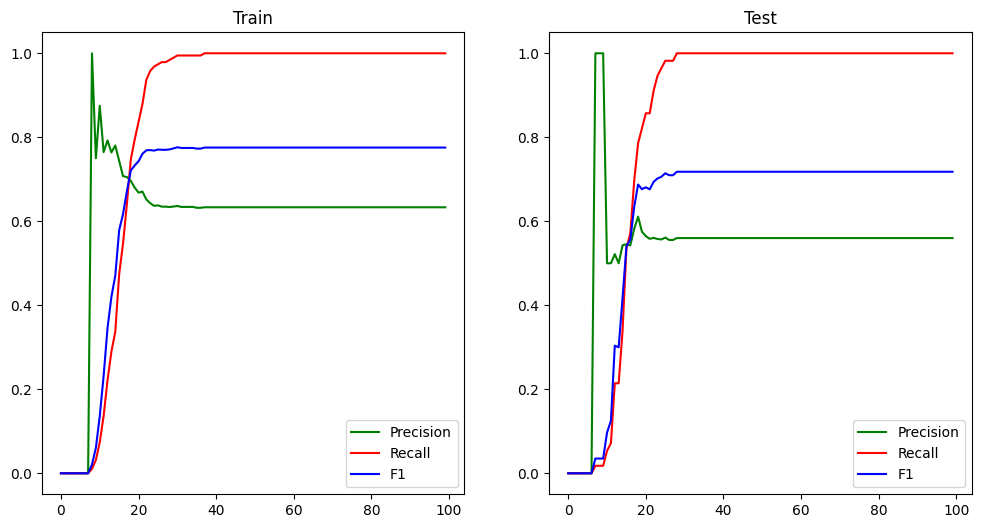

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Precision, Recall, F1 for Train
# You need to plot the Precision, Recall, and F1 score for the training set
plt.subplot(1, 2, 1)
plt.title("Train")
plt.plot(train_precision, color="green", label="Precision")
plt.plot(train_recall, color="red", label="Recall")
plt.plot(train_f1, color="blue", label="F1")

plt.legend()

# Plot the test metrics
# Plot the Precision, Recall, and F1 score for the test set
plt.subplot(1, 2, 2)
plt.title("Test")
plt.plot(test_precision, color="green", label="Precision")
plt.plot(test_recall, color="red", label="Recall")
plt.plot(test_f1, color="blue", label="F1")
plt.legend()
# Display the plots

plt.show()